<a href="https://colab.research.google.com/github/AlexanderLontke/ssl-remote-sensing/blob/vae-iteration/notebooks/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE Implementation

Adpated From: https://github.com/chenjie/PyTorch-CIFAR-10-autoencoder/blob/master/main.py

## Set up

In [1]:
# Numpy
import numpy as np

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Torchvision
import torchvision
import torchvision.transforms as transforms

# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# OS
import os
import argparse

from torch import Tensor

Machine setup

In [2]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

Hyperparameter setup

In [3]:
# Model Setup
class Hparams:
    def __init__(self):
        self.pretext_epochs = 50  # number of training epochs for pretext tasks
        self.classification_epochs = 5
        self.segmentation_epochs = 5
        self.seed = 1234  # randomness seed
        #self.cuda = False  # use nvidia gpu
        #self.img_size = 256  # image shape
        self.batch_size = 16
        self.lr = 1e-3
        self.weight_decay = 1e-6
        self.latent_dim = 256
        self.optim = "Adam"
        self.normalize = False

In [4]:
train_config = Hparams()

In [5]:
# Set random seed for reproducibility
SEED = train_config.seed
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

Directory setup

In [6]:
if not os.path.exists('./weights'):
    os.mkdir('./weights')

In [7]:
#autoencoder_dir = "./weights/autoencoder.pkl"

weights_dir = "./weights/"
#autoencoder_path_name = "autoencoder.pkl"
autoencoder_path_name = "autoencoder.pth"
classification_path_name = "classification_model.pth"
segmentation_path_name = "segmentation_model.pth"

autoencoder_dir = os.path.join(weights_dir,autoencoder_path_name)
classification_dir = os.path.join(weights_dir,classification_path_name)
segmentation_dir = os.path.join(weights_dir,segmentation_path_name)

# segmentation_autoencoder_dir = "./weights/autoencoder.pkl"

## Data

Description: EuroSAT, RGB, Normalized

In [8]:
# from torch.utils.data import DataLoader, random_split, SubsetRandomSampler, Subset

# def EurosatDataloader(batch_size, test_split_ratio = 0.2，normalized = True):

#     normalize = normalized

#     if normalized:
#       transform = transforms.Compose([
#           transforms.ToTensor(), 
#           transforms.Normalize(
#               mean = [0.3444, 0.3803, 0.4078],
#               std = [0.2037, 0.1366, 0.1148]) # params computed from the eurosat data
#           ])
#     else:
#         transform = transforms.Compose([
#         transforms.ToTensor()
#           ])
#     eurosat_ds = torchvision.datasets.EuroSAT(root='./data',
#                                             download=True, transform=transform)
    
#     dataset_size = len(eurosat_ds)
#     indices = list(range(dataset_size))
#     split_num = int(np.floor(test_split_ratio * dataset_size))

#     # Shuffle dataset
#     np.random.seed(train_config.seed)
#     np.random.shuffle(indices)
#     train_indices, test_indices = indices[split_num:], indices[:split_num]
#     # Creating PT data samplers and loaders:
#     train_sampler = SubsetRandomSampler(train_indices)
#     test_sampler = SubsetRandomSampler(test_indices)

#     trainloader = DataLoader(eurosat_ds, batch_size=batch_size,sampler = train_sampler)
#     valloader = DataLoader(eurosat_ds, batch_size=batch_size,sampler = test_sampler)

#     print("[LOG] Size of the image is: {}".format(eurosat_ds[0][0].shape))   
#     print("[LOG] Size of batch is: {}".format(batch_size))      
#     print("[LOG] Total number of batches in the trainloader: %d" %len(trainloader))
#     print("[LOG] Total number of batches in the valloader: %d" %len(valloader))
#     #print("[LOG] Total number of images: {}".format(len(dataloader[0])))

#     return trainloader,valloader

In [9]:
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler, Subset

class EurosatDataloader():

  # def __init__(self,batch_size,test_split_ratio = 0.2, normalize = True, root = './data',config = None):
  def __init__(self,test_split_ratio = 0.2, root = './data',config = None):
      super(EurosatDataloader,self).__init__()
      self.batch_size = config.batch_size
      self.test_split_ratio = test_split_ratio
      self.normalize = config.normalize
      self.config = config

      if self.normalize:
        transform = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize(
                mean = [0.3444, 0.3803, 0.4078],
                std = [0.2037, 0.1366, 0.1148]) # params computed from the eurosat data
            ])
      else:
        transform = transforms.Compose([
            transforms.ToTensor()
            ])
      
      self.ds = torchvision.datasets.EuroSAT(root='./data',
                                            download=True, transform=transform)
  
  def get_loader(self):
      dataset_size = len(self.ds)
      indices = list(range(dataset_size))
      split_num = int(np.floor(self.test_split_ratio * dataset_size))

      # Shuffle dataset
      np.random.seed(self.config.seed)
      np.random.shuffle(indices)
      train_indices, test_indices = indices[split_num:], indices[:split_num]
      # Creating PT data samplers and loaders:
      train_sampler = SubsetRandomSampler(train_indices)
      test_sampler = SubsetRandomSampler(test_indices)

      trainloader = DataLoader(self.ds, batch_size=self.batch_size,sampler = train_sampler)
      valloader = DataLoader(self.ds, batch_size=self.batch_size,sampler = test_sampler)

      print("[LOG] Size of the image is: {}".format(self.ds[0][0].shape))   
      print("[LOG] Size of batch is: {}".format(self.batch_size))      
      print("[LOG] Total number of batches in the trainloader: %d" %len(trainloader))
      print("[LOG] Total number of batches in the valloader: %d" %len(valloader))
      #print("[LOG] Total number of images: {}".format(len(dataloader[0])))

      return trainloader,valloader

In [10]:
eurosatloader = EurosatDataloader(test_split_ratio = 0.2, root = './data',config = train_config)

In [11]:
trainloader,valloader = eurosatloader.get_loader()

[LOG] Size of the image is: torch.Size([3, 64, 64])
[LOG] Size of batch is: 16
[LOG] Total number of batches in the trainloader: 1350
[LOG] Total number of batches in the valloader: 338


In [12]:
# transform = transforms.Compose([
#         transforms.ToTensor(), 
#         transforms.Normalize(
#             mean = [0.3444, 0.3803, 0.4078],
#             std = [0.2037, 0.1366, 0.1148])
#         ])
# trainset = torchvision.datasets.EuroSAT(root='./data',
#                                             download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
#                                               shuffle=True)

Calculation of mean and sd: https://www.binarystudy.com/2022/04/how-to-normalize-image-dataset-inpytorch.html

In [13]:
# def batch_mean_and_sd(loader):
    
#     cnt = 0
#     fst_moment = torch.empty(3)
#     snd_moment = torch.empty(3)

#     for images, _ in loader:
#         b, c, h, w = images.shape
#         nb_pixels = b * h * w
#         sum_ = torch.sum(images, dim=[0, 2, 3])
#         sum_of_square = torch.sum(images ** 2,
#                                   dim=[0, 2, 3])
#         fst_moment = (cnt * fst_moment + sum_) / (
#                       cnt + nb_pixels)
#         snd_moment = (cnt * snd_moment + sum_of_square) / (
#                             cnt + nb_pixels)
#         cnt += nb_pixels

#     mean, std = fst_moment, torch.sqrt(
#       snd_moment - fst_moment ** 2)        
#     return mean,std
  
# mean, std = batch_mean_and_sd(trainloader)
# print("mean and std: \n", mean, std)
mean = [0.3444, 0.3803, 0.4078]
std = [0.2037, 0.1366, 0.1148]

In [14]:
# batch_size = 16

In [15]:
# trainloader,valloader = EurosatDataloader(batch_size = train_config.batch_size,test_split_ratio = 0.2)

### Plot images

In [16]:
def imshow(img):
    fig, ax = plt.subplots(1, figsize=(20,20))
    npimg = img.cpu().numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [17]:
classes = (
    "AnnualCrop",
    "Forest",
    "HerbaceousVegetation",
    "Highway",
    "Industrial",
    "Pasture",
    "PermanentCrop",
    "Residential",
    "River",
    "SeaLake"
)

GroundTruth:
 SeaLake Highway Forest Pasture PermanentCrop AnnualCrop River PermanentCrop 
 River River Pasture HerbaceousVegetation AnnualCrop PermanentCrop AnnualCrop


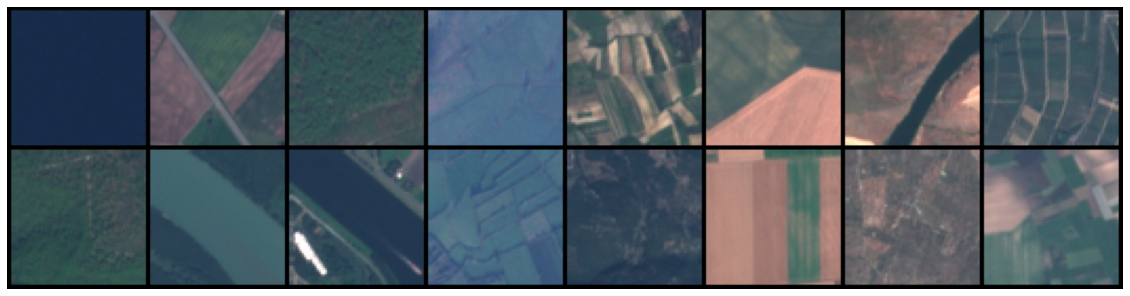

In [18]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('GroundTruth:\n', " ".join('%5s' % classes[labels[j]] for j in range(8)),"\n"," ".join('%5s' % classes[labels[j]] for j in range(9,16)))
imshow(torchvision.utils.make_grid(images))

## Model

ResNet18 Script: \\
Encoder copied from https://github.com/Lightning-AI/lightning-bolts/blob/master/pl_bolts/models/autoencoders/components.py \\
Decoder copied from https://github.com/Lightning-AI/lightning-bolts/blob/master/pl_bolts/models/autoencoders/components.py 

In [19]:
class Interpolate(nn.Module):
    """nn.Module wrapper for F.interpolate."""

    def __init__(self, size=None, scale_factor=None):
        super().__init__()
        self.size, self.scale_factor = size, scale_factor

    def forward(self, x):
        return F.interpolate(x, size=self.size, scale_factor=self.scale_factor)

In [20]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding."""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

In [21]:
def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution."""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [22]:
def resize_conv3x3(in_planes, out_planes, scale=1):
    """upsample + 3x3 convolution with padding to avoid checkerboard artifact."""
    if scale == 1:
        return conv3x3(in_planes, out_planes)
    return nn.Sequential(Interpolate(scale_factor=scale), conv3x3(in_planes, out_planes))

In [23]:
def resize_conv1x1(in_planes, out_planes, scale=1):
    """upsample + 1x1 convolution with padding to avoid checkerboard artifact."""
    if scale == 1:
        return conv1x1(in_planes, out_planes)
    return nn.Sequential(Interpolate(scale_factor=scale), conv1x1(in_planes, out_planes))

In [24]:
class EncoderBlock(nn.Module):
    """ResNet block, copied from https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L35."""

    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [25]:
class DecoderBlock(nn.Module):
    """ResNet block, but convs replaced with resize convs, and channel increase is in second conv, not first."""

    expansion = 1

    def __init__(self, inplanes, planes, scale=1, upsample=None):
        super().__init__()
        self.conv1 = resize_conv3x3(inplanes, inplanes)
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = resize_conv3x3(inplanes, planes, scale)
        self.bn2 = nn.BatchNorm2d(planes)
        self.upsample = upsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.upsample is not None:
            identity = self.upsample(x)

        out += identity
        out = self.relu(out)

        return out

In [26]:
class ResNetEncoder(nn.Module):
    def __init__(self, block, layers,input_dim):
        super().__init__()

        self.inplanes = 64
        self.input_dim = input_dim
        self.conv1 = nn.Conv2d(self.input_dim, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        #self.fc = nn.Sequential()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        #x = self.fc(x)
        return x

In [27]:
model_encoder = ResNetEncoder(EncoderBlock, [2, 2, 2, 2],input_dim = 3)

In [28]:
# from torchsummary import summary
# # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model_encoder = model_encoder.to(device)
# summary(model_encoder,(3,64,64))

In [29]:
# import torchvision.models as models

# # compare with the Pytorch resnet18 model
# model_test = models.resnet18(pretrained = False)
# model_test = model_test.to(device)
# summary(model_test,(3,64,64))

In [30]:
class ResNetDecoder(nn.Module):
    """Resnet in reverse order."""

    def __init__(self, block, layers, latent_dim, input_height,output_dim):
        super().__init__()

        self.expansion = block.expansion
        self.inplanes = 512 * block.expansion
        self.input_height = input_height

        self.upscale_factor = 8

        self.linear = nn.Linear(latent_dim, self.inplanes * 4 * 4)

        self.layer1 = self._make_layer(block, 256, layers[0], scale=2)
        self.layer2 = self._make_layer(block, 128, layers[1], scale=2)
        self.layer3 = self._make_layer(block, 64, layers[2], scale=2)
        self.layer4 = self._make_layer(block, 64, layers[3], scale=2)
        self.upscale_factor *= 2
        self.upscale = Interpolate(scale_factor=2)
        self.upscale_factor *= 2
        
        self.upscale1 = Interpolate(size=input_height // self.upscale_factor)

        self.conv1 = nn.Conv2d(64 * block.expansion, output_dim, kernel_size=3, stride=1, padding=1, bias=False)

    def _make_layer(self, block, planes, blocks, scale=1):
        upsample = None
        if scale != 1 or self.inplanes != planes * block.expansion:
            upsample = nn.Sequential(
                resize_conv1x1(self.inplanes, planes * block.expansion, scale),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, scale, upsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.linear(x)

        # NOTE: replaced this by Linear(in_channels, 514 * 4 * 4)
        # x = F.interpolate(x, scale_factor=4)

        x = x.view(x.size(0), 512 * self.expansion, 4, 4)
        x = self.upscale1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.upscale(x)

        x = self.conv1(x)
        return x

In [31]:
def resnet18_encoder():
    return ResNetEncoder(EncoderBlock, [2, 2, 2, 2],input_dim = 3)

In [32]:
def resnet18_decoder(latent_dim, input_height):
    return ResNetDecoder(DecoderBlock, [2, 2, 2, 2], latent_dim, input_height,output_dim=3)

In [33]:
# set latent dimension
d  = train_config.latent_dim
print("[LOG] Latent dimension for VAE is: ", d)

[LOG] Latent dimension for VAE is:  256


In [34]:
import torchvision.models as models

class VariationalAutoencoder(nn.Module):
    def __init__(self,enc_out_dim = 512,latent_dim=d, input_height=64):
        super().__init__()

        self.encoder = resnet18_encoder()
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        # set optimizer
        if train_config.optim == "Adam":
          # set learning rate
          return torch.optim.Adam(self.parameters(), lr=train_config.lr)

    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        # measure prob of seeing image under p(x|z)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch):
        x = batch
        x = x.float()

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        return x_encoded,x_hat,elbo

In [35]:
def print_model(encoder, decoder):
    print("============== Encoder ==============")
    print(encoder)
    print("============== Decoder ==============")
    print(decoder)
    print("")

In [36]:
# Create model
# model has been moved to device
autoencoder =  VariationalAutoencoder()
autoencoder.to(device)
# print_model(autoencoder.encoder, autoencoder.decoder)

VariationalAutoencoder(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): EncoderBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): EncoderBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0

In [37]:
# check if model is on cuda
print("Device: ", device)
print("Is model on cuda? ", next(autoencoder.parameters()).is_cuda)

Device:  cuda
Is model on cuda?  True


In [38]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in autoencoder.parameters():

    # collect number of parameters
    num_params += param.numel()
    
# print the number of model paramters
print('[LOG] Number of to be trained ResNet model parameters: {}.'.format(num_params))

[LOG] Number of to be trained ResNet model parameters: 20068993.


In [39]:
# Training and testing the VAE

# epochs = train_config.pretext_epochs
epochs = 5
for epoch in range(0, epochs):
    # Training
    if epoch > 0:  # test untrained net first
        autoencoder.train()
        train_loss = 0
        for y, _ in trainloader:
            y = y.to(device)
            # ===================forward=====================
            loss = autoencoder.training_step(y)[2]
            train_loss += loss.item()/ len(trainloader)
            # ===================backward====================
            autoencoder.configure_optimizers().zero_grad()
            loss.backward()
            autoencoder.configure_optimizers().step()
        #print(f'====> Epoch: {epoch} Average training loss: {train_loss :.4f} Average validation loss: {val_loss :.4f }')
            
        # Specify you are in evaluation mode
        autoencoder.eval()
        with torch.no_grad():
            val_loss = 0
            for y,_ in valloader:
                y = y.to(device)
                # labels = labels.to(device)
                # calculate outputs by running images through the network
                output = autoencoder.training_step(y)[2]
                val_loss += output.item()/ len(valloader)
                # the class with the highest energy is what we choose as prediction
                # collect mini-batch reconstruction loss
            # ===================log========================
        print(f'====> Epoch: {epoch} Average training loss: {train_loss :.4f} Average validation loss: {val_loss :.4f}')

      # torch.save(autoencoder.state_dict(), autoencoder_dir)

    # if epoch == 0:
    #     val_loss = 0
    #     best_val_loss = val_loss
    # else:
    #     if val_loss <= best_val_loss:
    #         best_val_loss = val_loss
    #         # Save model
    #         torch.save(autoencoder.state_dict(), autoencoder_dir)

    # print epoch loss

====> Epoch: 1 Average training loss: 3615.1642 Average validation loss: 1099483056363428736.0000
====> Epoch: 2 Average training loss: -8087.4946 Average validation loss: 149967119980455849468784329883648.0000
====> Epoch: 3 Average training loss: -10106.9422 Average validation loss: -5560.1914


KeyboardInterrupt: ignored

In [40]:
print('Finished Training')
print('Saving Model...')
# if not os.path.exists('./weights'):
#     os.mkdir('./weights')
print("Saved path is ", autoencoder_dir)
torch.save(autoencoder.state_dict(), autoencoder_dir)

Finished Training
Saving Model...
Saved path is  ./weights/autoencoder.pth


GroundTruth:  SeaLake AnnualCrop Residential Pasture Industrial PermanentCrop SeaLake Pasture Industrial Industrial River Highway HerbaceousVegetation SeaLake Pasture Forest


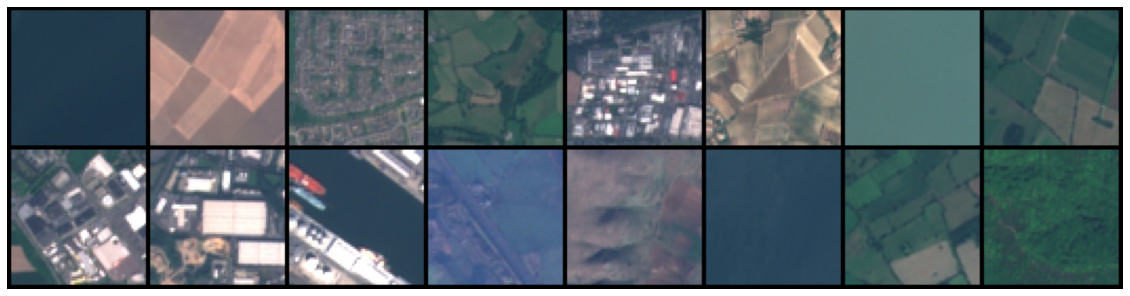

In [41]:
autoencoder.load_state_dict(torch.load(autoencoder_dir))
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))
imshow(torchvision.utils.make_grid(images))
images = Variable(images.cuda())

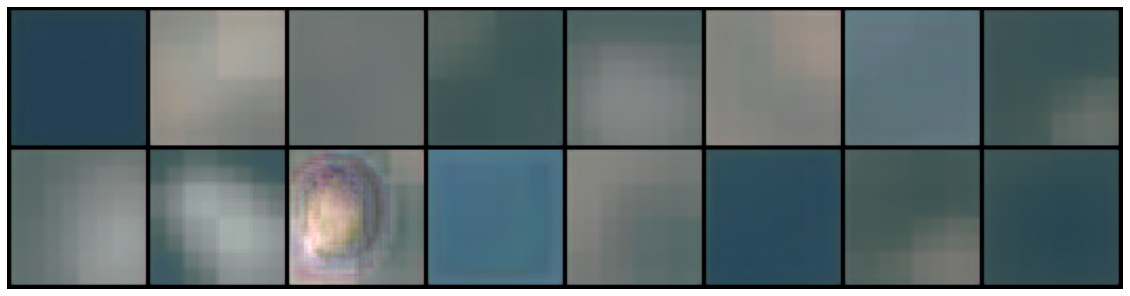

In [42]:
decoded_imgs = autoencoder.training_step(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs))

In [ ]:
# autoencoder.state_dict()

# Downstream task

## Load best model

In [43]:
import os
import torch

def best_model_loader(pretext_model,pretext_model_dir,pretext_model_path):

    # restore pre-trained model snapshot
    best_model_name = os.path.join(pretext_model_dir, pretext_model_path)

    # load state_dict from path
    state_dict_best = torch.load(best_model_name, map_location=torch.device('cpu'))

    # init pre-trained model class
    best_model = pretext_model

    # load pre-trained models
    best_model.load_state_dict(state_dict_best)

    return best_model

In [44]:
#best_model = best_model_loader(autoencoder,"./weights/","autoencoder.pkl")
best_model = best_model_loader(autoencoder,weights_dir,autoencoder_path_name)

In [45]:
from copy import deepcopy
best_model_encoder = deepcopy(best_model.encoder)

In [46]:
best_model_encoder

ResNetEncoder(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): EncoderBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): EncoderBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inpla

In [58]:

# print(best_model)

In [ ]:
# new_weight = torch.Tensor(module.out_channels, new_in_channels // module.groups, *module.kernel_size)

#     for i in range(new_in_channels):
#         new_weight[:, i] = weight[:, i % default_in_channels]

#     new_weight = new_weight * (default_in_channels / new_in_channels)
#     module.weight = nn.parameter.Parameter(new_weight)

## Downstream task: Classification

In [49]:
class FullyConnectedBlock(nn.Module):
    """
    Model used for ML-Challenge
    """

    def __init__(self, input_dim: int):
        """
        Model definition
        """
        super().__init__()
        self.fc2 = nn.Linear(512, 124)
        self.fc3 = nn.Linear(124, 10)

    def forward(self, x):
        """
        Model forward pass
        :param x: List of image samples
        :return:
        """
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [50]:
class DownstreamNet(nn.Module):
    """
    Model used for ML-Challenge
    """

    def __init__(self, encoder=None):
        """
        Model definition
        """
        super().__init__()
        self.encoder = encoder
        self.fc = FullyConnectedBlock(input_dim=512)

    def forward(self, x):
        """
        Model forward pass
        :param x: List of image samples
        :return:
        """
        x = self.encoder(x)
        x = self.fc(x)
        return x

In [51]:
print("Device used: {}".format(device))

Device used: cuda


In [54]:
model = DownstreamNet(encoder = best_model.encoder)
# freeze backbone layers
for l in list(model.encoder.children()):
  for param in l.parameters():
    param.requires_grad = False

In [55]:
# define the optimization criterion / loss function
loss_criterion = nn.CrossEntropyLoss().to(device)

# define learning rate and optimization strategy
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
model.to(device)

In [57]:
from tqdm import tqdm
from datetime import datetime

# specify the training parameters
num_epochs = 10  # number of training epochs
train_epoch_losses = []
validation_epoch_losses = []


for epoch in range(num_epochs):
    model.train()
    # init collection of mini-batch losses
    train_mini_batch_losses = []

    # iterate over all-mini batches
    for i, (images, labels) in tqdm(enumerate(trainloader), total=len(trainloader)):

        # push mini-batch data to computation device
        images = images.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        optimizer.zero_grad()
        out = model(images)
        loss = loss_criterion(out, labels)
        loss.backward()
        optimizer.step()

        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())

    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)
    train_epoch_losses.append(train_epoch_loss)

    # Specify you are in evaluation mode
    model.eval()
    with torch.no_grad():
        validation_mini_batch_losses = []
        for (images, labels) in valloader:
            images = images.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            validation_epoch_loss = loss_criterion(outputs, labels)
            # collect mini-batch reconstruction loss
            validation_mini_batch_losses.append(loss.data.item())
        validation_epoch_loss = np.mean(validation_mini_batch_losses)
        validation_epoch_losses.append(validation_epoch_loss)

    # # print epoch loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print(
        #f"[LOG {now}] epoch: {epoch+1} train-loss: {train_epoch_loss} validation-loss: {validation_epoch_loss}"
        f"[LOG {now}] epoch: {epoch+1} train-loss: {train_epoch_loss}"
    )
torch.save(model.state_dict(), classification_dir)

100%|██████████| 338/338 [00:07<00:00, 46.98it/s]


[LOG 20221111-23:27:20] epoch: 1 train-loss: 1.88348371531131


100%|██████████| 338/338 [00:07<00:00, 46.80it/s]


[LOG 20221111-23:27:27] epoch: 2 train-loss: 1.5254919021087285


100%|██████████| 338/338 [00:07<00:00, 47.66it/s]


[LOG 20221111-23:27:35] epoch: 3 train-loss: 1.4043694394227315


100%|██████████| 338/338 [00:07<00:00, 47.21it/s]


[LOG 20221111-23:27:42] epoch: 4 train-loss: 1.339709050909302


100%|██████████| 338/338 [00:07<00:00, 47.26it/s]


[LOG 20221111-23:27:49] epoch: 5 train-loss: 1.2955787754975832


100%|██████████| 338/338 [00:07<00:00, 47.81it/s]


[LOG 20221111-23:27:56] epoch: 6 train-loss: 1.2656349968275376


100%|██████████| 338/338 [00:06<00:00, 49.13it/s]


[LOG 20221111-23:28:03] epoch: 7 train-loss: 1.2547058424300697


100%|██████████| 338/338 [00:06<00:00, 49.07it/s]


[LOG 20221111-23:28:10] epoch: 8 train-loss: 1.2204994113134915


100%|██████████| 338/338 [00:06<00:00, 49.21it/s]


[LOG 20221111-23:28:17] epoch: 9 train-loss: 1.1946306637758335


100%|██████████| 338/338 [00:06<00:00, 49.37it/s]


[LOG 20221111-23:28:23] epoch: 10 train-loss: 1.1943447806778744


In [58]:
from typing import List

def visualize_losses_during_training(
    train_epoch_losses: List[float], validation_epoch_losses: List[float]
) -> None:
    """
    Visualizes losses gathered during training.
    :param train_epoch_losses: List containing training loss per epoch
    :param validation_epoch_losses: List containing validation loss per epoch
    :return: None
    """
    # prepare plot
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # add grid
    ax.grid(linestyle="dotted")

    # plot the training epochs vs. the epochs' classification error
    ax.plot(
        np.array(range(1, len(train_epoch_losses) + 1)),
        train_epoch_losses,
        label="epoch train. loss (blue)",
    )
    ax.plot(
        np.array(range(1, len(validation_epoch_losses) + 1)),
        validation_epoch_losses,
        label="epoch val. loss (blue)",
    )
    # add axis legends
    ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
    ax.set_ylabel("[Classification Error $\\mathcal{L}^{CE}$]", fontsize=10)

    # set plot legend
    plt.legend(loc="upper right", numpoints=1, fancybox=True)

    # add plot title
    plt.title("Training Epochs $e_i$ vs. Classification Error $L^{CE}$", fontsize=10)

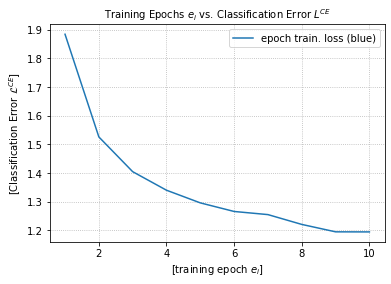

In [59]:
visualize_losses_during_training(train_epoch_losses, validation_epoch_losses)

In [60]:
y_pred = []
y_true = []
# iterate over test data
model.eval()
with torch.no_grad():
    for (images, labels) in tqdm(valloader, desc="Predict labels"):
        images = images.to(device)

        outputs = model(images)  # Feed Network
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())  # Save Prediction
        y_true.extend(labels.numpy())  # Save Truth

Predict labels: 100%|██████████| 338/338 [00:04<00:00, 68.89it/s]


In [61]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.70      0.61       602
           1       0.58      0.93      0.72       586
           2       0.44      0.56      0.49       594
           3       0.53      0.27      0.36       515
           4       0.93      0.79      0.85       488
           5       0.54      0.69      0.60       418
           6       0.40      0.31      0.35       499
           7       0.53      0.69      0.60       596
           8       0.62      0.40      0.48       511
           9       0.97      0.37      0.54       591

    accuracy                           0.57      5400
   macro avg       0.61      0.57      0.56      5400
weighted avg       0.61      0.57      0.56      5400



## Downstream Task: Segmentation

### Load data

In [52]:
import gdown

gdown.download('https://drive.google.com/u/1/uc?id=1zGalZSCxgnmZM7zMm0qfRrnOXyD6IUX1&export=download')

Downloading...
From: https://drive.google.com/u/1/uc?id=1zGalZSCxgnmZM7zMm0qfRrnOXyD6IUX1&export=download
To: /content/lab-seg-data.tar.gz
100%|██████████| 5.37G/5.37G [02:07<00:00, 42.3MB/s]


'lab-seg-data.tar.gz'

In [53]:
import tarfile
import os

data_base_path = '/content/'
data_folder = 'lab-seg-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

with tarfile.open(tar_path, mode='r') as tar:
    tar.extractall(path=data_base_path)

In [54]:
!pip install rasterio torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 15.2 MB/s 
     |████████████████████████████████| 529 kB 93.5 MB/s 


In [55]:
import rasterio as rio
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import torch 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
import cv2
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import random

In [56]:
class SEN12FLOODS():
    """SEN12FLOODS Segmentation Dataset."""
    def __init__(self, root='chips/', split='train', transforms=None, **kwargs):
        super(SEN12FLOODS, self).__init__()
        
        # Loop over available data and create pairs of Sentinel 1 and Sentinel 2 images, co-registered,
        # with corresponding groundtruth, and store the paths in lists. 
        self.s2_images, self.s2_masks, self.s1_images, self.s1_masks = self._get_sen2flood_pairs(root, split)
        
        # Make sure that for each data point we have all the values we need.
        assert (len(self.s2_images) == len(self.s2_masks) == len(self.s1_images) == len(self.s1_masks))
        if len(self.s2_images) == 0:
            raise RuntimeError("Found 0 images in subfolders of:" + root + "\n")

        print('Found {} images in the folder {}'.format(len(self.s2_images), root  + split))
        
        self.transforms = transforms
        
        # Initialise the data augmentation we will use: horizontal and vertical flipping, random affine translation, resizing
        if self.transforms:
            augmentation = A.Compose(
                [
                    A.Resize(height=256, width=256, p=1, interpolation=cv2.INTER_NEAREST),
                    A.Affine(scale=2, translate_px=5, rotate=20, p=0.5),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    ToTensorV2()
                ] , additional_targets={'image0': 'image'}
            )
            self.augmentation = augmentation

        else:
            augmentation = A.Compose(
                [
                    A.Resize(height=256, width=256, p=1, interpolation=cv2.INTER_NEAREST),
                    ToTensorV2(),
                ] , additional_targets={'image0': 'image'}
            )
            self.augmentation = augmentation

        # turn lists into arrays
        self.s2_images = np.array(self.s2_images)
        self.s1_images = np.array(self.s1_images)
        self.s2_masks = np.array(self.s2_masks)
        self.s1_masks = np.array(self.s1_masks)

    def __len__(self):
        return len(self.s2_images)

    def __getitem__(self, index):
        # Loop over all bands, and create a concatenated array for sentinel-2 data
        bands = []
        for file in ['B1.tif', 'B2.tif', 'B3.tif', 'B4.tif', 'B5.tif', 'B6.tif', 'B7.tif',
                     'B8.tif', 'B8A.tif', 'B9.tif', 'B10.tif', 'B11.tif', 'B12.tif']:
            band = rio.open(os.path.join(self.s2_images[index], file))
            bands.append(band.read())
        s2_img = np.concatenate(bands, axis=0)
        s2_img = np.array(s2_img, dtype=np.float32)
        #print(s2_img.shape)
        
        # Loop over both polarization, and create a concatenated array for sentinel-1 data
        bands = []
        for file in ['VH.tif', 'VV.tif']:
            band = rio.open(os.path.join(self.s1_images[index], file))
            band_array = band.read()
            if np.isfinite(band_array).all():
                bands.append(band.read())
            else:
                bands.append(np.zeros(band_array.shape))
        s1_img = np.concatenate(bands, axis=0)
        s1_img = np.array(s1_img, dtype=np.float32)
        
        # The two channels of Sentinel-1 (VV and VH) have both negative and positive values. 
        # We normalize them to lie between 0 and 1 by applying [min-max normalization with min = -77 and max = 26.
        s1_img = np.clip(s1_img, a_min=-77, a_max=26)
        s1_img = (s1_img + 77) / (26 + 77)
        
        # The water labels for Sentinel 1 and Sentinel 2 can be slightly different (since scenes are taken around 3 days apart)
        # We read the water label mask associated to Sentinel 2. 
        mask = rio.open(self.s2_masks[index])
        ####################
        #mask_img = mask.read().squeeze()
        mask_img = mask.read().squeeze()
        #print(mask_img.shape)
        #np.expand_dims(mask_img, axis=0)
        # mask_img = np.reshape(mask_img,(4, 256, 256))
        # mask_img = np.array(mask_img, dtype=np.float32)
        # mask_img =  np.reshape(mask_img, (13,256,256))

        # Apply same data augmentation for both sentinel 2 and sentinel 1 images, and the mask.
        augmented_data = self.augmentation(image=np.transpose(s2_img, (1, 2, 0)), image0=np.transpose(s1_img, (1, 2, 0)), mask=mask_img)
        
        # Define output tensor
        output_tensor = {
            "s2_img": augmented_data['image'],
            "s1_img": augmented_data['image0'],
            "s2_imgfile": self.s2_images[index],
            "s1_imgfile": self.s1_images[index],
            "mask": augmented_data['mask'],
            #"mask": np.expand_dims(augmented_data['mask'], axis=0),
        }

        return output_tensor

    def _get_sen2flood_pairs(self, folder, split):
        """
        Constructs Sentinel2 and Sentinel1 pairs

        Arguments
        ----------
            folder : str
                Image folder name 
            split : str
                train or val split
        Returns
        -------
            s2_img_paths : list
                List of Sentinel 2 image path
            s2_mask_paths : list
                List of Sentinel 2 water mask path
            s1_img_paths : list
                List of Sentinel 1 image path
            s1_mask_paths : list 
                List of Sentinel 1 water mask path
        """
        s2_img_paths = []
        s2_mask_paths = []
        s1_img_paths = []
        s1_mask_paths = []

        img_folder = os.path.join(folder, split)
        
        # loop over the image folder (train or validation)
        for filename in os.listdir(img_folder):
            if filename not in ['._.DS_Store', '.DS_Store']:
                for file in os.listdir(os.path.join(img_folder, filename, 's2')):
                    if file not in ['._.DS_Store', '.DS_Store']:
                        # Get the Image ID (as explained in the dataset section)
                        image_id = file.split('_')[-1]
                        
                        # Store Sentinel 2 image and mask paths in lists
                        s2_imgpath = os.path.join(img_folder, filename, 's2', file)
                        s2_maskpath = os.path.join(img_folder, filename, 's2', file, 'LabelWater.tif')
                        
                        # Using the Image ID, store co-registered Sentinel 1 image and mask paths in lists
                        s1_files = os.listdir(os.path.join(img_folder, filename, 's1'))
                        s1_file = [file for file in s1_files if file.endswith(image_id)][0]
                        s1_imgpath = os.path.join(img_folder, filename, 's1', s1_file)
                        s1_maskpath = os.path.join(img_folder, filename, 's1', s1_file, 'LabelWater.tif')
                        
                        if os.path.isfile(s1_maskpath):
                            s2_img_paths.append(s2_imgpath)
                            s2_mask_paths.append(s2_maskpath)
                            s1_img_paths.append(s1_imgpath)
                            s1_mask_paths.append(s1_maskpath)
                        else:
                            print('cannot find the S1 Mask:', s1_maskpath)

        return s2_img_paths, s2_mask_paths, s1_img_paths, s1_mask_paths
    
    def visualize_observation(self, idx):
        """
        Visualise Sentinel1, Sentinel2, and water mask. 

        Arguments
        ----------
            idx : int
                Data index
        """
        sample = self.__getitem__(idx)

        s2_image = sample.get("s2_img").squeeze()
        s1_image = sample.get("s1_img").squeeze()
        mask = sample.get("mask")
        
        print(sample.get('s2_imgfile'))
        print(sample.get('s1_imgfile'))

        fig, axs = plt.subplots(1, 3, figsize=(17, 6))
        
        s1_img_vh = s1_image[0, :, :]
        s1_img_vh = s1_img_vh / s1_img_vh.max()

        axs[0].imshow(s1_img_vh)
        axs[0].set_title("Sentinel-1 VH")
        axs[0].axis('off')
        
        s2_img_rgb = s2_image[[3, 2, 1], :, :]
        s2_img_rgb = np.transpose(s2_img_rgb, (1, 2, 0))
        s2_img_rgb = s2_img_rgb / s2_img_rgb.max()

        axs[1].imshow(s2_img_rgb)
        axs[1].set_title("Sentinel-2 RGB")
        axs[1].axis('off')

        mask = mask.squeeze()

        axs[2].imshow(mask, cmap='Blues')
        axs[2].set_title("Groundtruth Mask")
        axs[2].axis('off')

        plt.show()

In [57]:
trainset = SEN12FLOODS(
        root='/content/chips/',
        transforms=True,
        split='train')

valset = SEN12FLOODS(
    root='/content/chips/', 
    split='val')


train_loader = DataLoader(
    trainset,
    batch_size=8,
    pin_memory=True)

val_loader = DataLoader(
    valset,
    batch_size=8,
    pin_memory=True)

Found 688 images in the folder /content/chips/train
Found 211 images in the folder /content/chips/val


In [58]:
next(iter(train_loader))["mask"].shape

torch.Size([8, 256, 256])

In [59]:
next(iter(train_loader))["s2_img"].shape

torch.Size([8, 13, 256, 256])

/content/chips/train/749aca10-a39b-4321-8322-100dd6f976d4/s2/S2B_MSIL1C_20190214T004709_N0207_R102_T54KVF_20190214T020418_05120-04608
/content/chips/train/749aca10-a39b-4321-8322-100dd6f976d4/s1/S1B_IW_GRDH_1SDV_20190215T090752_20190215T090826_014954_01BECA_6119_05120-04608


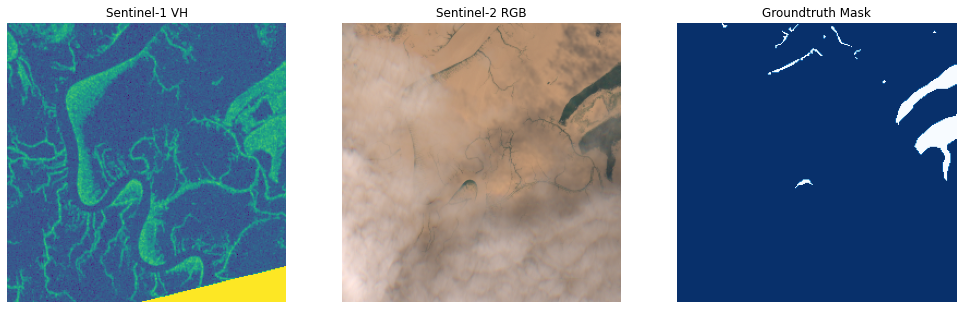

In [60]:
trainset.visualize_observation(95)

## Model

In [47]:
new_in_channels = 13

In [48]:
def patch_first_conv(encoder, new_in_channels, default_in_channels=3):

    for module in encoder.modules():
            if isinstance(module, nn.Conv2d) and module.in_channels == 3:
                print(module)
                break

    weight = module.weight.detach()          
    module.in_channels = 13

    new_weight = torch.Tensor(module.out_channels, new_in_channels // module.groups, *module.kernel_size)
    for i in range(new_in_channels):
        new_weight[:, i] = weight[:, i % default_in_channels]

    new_weight = new_weight * (default_in_channels / new_in_channels)
    module.weight = nn.parameter.Parameter(new_weight)

In [49]:
patch_first_conv(best_model_encoder,13)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [78]:
import torch.nn as nn
import torchvision.models


def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )


class ResNetUNet(nn.Module):
  def __init__(self, n_class,encoder = None):
    super().__init__()
    
    # test base mode: pretrained resnet 18 of imagenet
    #self.base_model = torchvision.models.resnet18(pretrained=True)
    # base model from our pre-trained model
    patch_first_conv
    self.base_model = encoder
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    # from 3 to 13
    self.conv_original_size0 = convrelu(13, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    # concat: skip connection to merge features from z_layer3
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    # concat: skip connection to merge features from z_layer2
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    # concat: skip connection to merge features from z_layer1
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

In [51]:
# # Create the convolution block
# class DoubleConv(nn.Module):
#     """
#     The DoubleConv object is composed of two successive blocks of convolutional layers, batch normalization and ReLU.
#     """
#     def __init__(self, in_channels, out_channels, mid_channels=None):
#         super().__init__()
#         if not mid_channels:
#             mid_channels = out_channels

#         # Create a sequential module. 
#         # nn.Sequential is a module inside which you can put other modules that will be applied one after the other. 
#         self.double_conv = nn.Sequential(
#             # First convolutional layer 
#             nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),

#             # First batchnormalization
#             nn.BatchNorm2d(mid_channels),

#             # First ReLU activation function
#             nn.ReLU(inplace=True),

#             # Second convolutional layer 
#             nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),

#             # Second batchnormalization
#             nn.BatchNorm2d(out_channels),

#             # Second ReLU activation function
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         return self.double_conv(x)


# # Create the downsampling block
# class Down(nn.Module):
#     """
#     The Down object is composed of a maxpooling layer followed by the DoubleConv block defined above.
#     """
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         # Create a sequential module. 
#         self.maxpool_conv = nn.Sequential(
#             # 2D max pooling layer with a kernel size of 2 (meaning spatial dimension will be divided by two)
#             nn.MaxPool2d(2),

#             DoubleConv(in_channels, out_channels)
#         )

#     def forward(self, x):
#         return self.maxpool_conv(x)


# # Create the upsampling block
# class Up(nn.Module):
#     """
#     The Up object is composed of an upsampling layer (bilinear interpolation) followed by the DoubleConv block defined above.
#     """
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         # upsampling layer with a scale factor of 2 (meaning spatial dimension will be multiplied by two)
#         self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

#         self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

#     def forward(self, x1, x2):
#         x1 = self.up(x1)
 
#         diffY = x2.size()[2] - x1.size()[2]
#         diffX = x2.size()[3] - x1.size()[3]

#         x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
#                         diffY // 2, diffY - diffY // 2])

#         x = torch.cat([x2, x1], dim=1)
#         return self.conv(x)

    
# # Create the last convolution block, responsible of the pixel classification
# class OutConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(OutConv, self).__init__()
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

#     def forward(self, x):
#         return self.conv(x)

In [125]:
# class UNet(nn.Module):
#     def __init__(self, in_channels, n_classes):
#         super(UNet, self).__init__()
        
#         self.inc = DoubleConv(in_channels, 64)
        
#         # Initialise the Encoder
#         self.down1 = Down(64, 128)
#         self.down2 = Down(128, 256)
#         self.down3 = Down(256, 512)
#         self.down4 = Down(512, 1024 // 2)
        
#         # Initialise the Decoder
#         self.up1 = Up(1024, 512 // 2)
#         self.up2 = Up(512, 256 // 2)
#         self.up3 = Up(256, 128 // 2)
#         self.up4 = Up(128, 64)
        
#         # Last convolution block
#         self.outc = OutConv(64, n_classes)

#     def forward(self, x):
#         x1 = self.inc(x)

#         # In these 4 downsampling blocks, the size of the image is gradually reduced
#         # while the depth is gradually increased.    
#         x2 = self.down1(x1)
#         x3 = self.down2(x2)
#         x4 = self.down3(x3)
#         x5 = self.down4(x4)

#         # In these 4 upsampling  blocks, the size of the image is gradually increased
#         # while the depth is gradually reduced.
#         x = self.up1(x5, x4)
#         x = self.up2(x, x3)
#         x = self.up3(x, x2)
#         x = self.up4(x, x1)
        
#         x = self.outc(x)
#         return x

In [126]:
# model = UNet(3, 1)

In [85]:
# # our pretrained model
model = ResNetUNet(1,encoder = best_model_encoder)

# pretrained ResNet18 on ImageNet
# model = ResNetUNet(1,encoder = torchvision.models.resnet18(pretrained=True))

In [80]:
# model

ResNetUNet(
  (base_model): ResNetEncoder(
    (conv1): Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): EncoderBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): EncoderBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [82]:
from torchsummary import summary
summary(model.to(device), input_size=(13, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           7,552
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5         [-1, 64, 128, 128]          40,768
            Conv2d-6         [-1, 64, 128, 128]          40,768
       BatchNorm2d-7         [-1, 64, 128, 128]             128
       BatchNorm2d-8         [-1, 64, 128, 128]             128
              ReLU-9         [-1, 64, 128, 128]               0
             ReLU-10         [-1, 64, 128, 128]               0
        MaxPool2d-11           [-1, 64, 64, 64]               0
        MaxPool2d-12           [-1, 64, 64, 64]               0
           Conv2d-13           [-1, 64, 64, 64]          36,864
           Conv2d-14           [-1, 64,

In [105]:
# model

In [83]:
# # freeze backbone layers
# for l in model.base_layers:
#   for param in l.parameters():
#     param.requires_grad = False

In [86]:
model = model.to(device)

In [108]:
# from torchsummary import summary
# summary(model, input_size=(3, 256, 256))

## Training

In [87]:
# Define a learning rate
learning_rate = 0.001

# Initialise the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [88]:
# Initialise the loss function and move it to the GPU if available 
criterion = torch.nn.BCEWithLogitsLoss().to(device)

In [89]:
next(iter(train_loader))["s2_img"].shape

torch.Size([8, 13, 256, 256])

In [90]:
# # set weights path
# if not os.path.exists('./weights'):
#     os.mkdir('./weights')

In [92]:
# model

In [72]:
# model = best_model_encoder

In [ ]:
# model.to(device)
# for i, batch in enumerate(train_loader):
#     out = model(batch["s2_img"].float().to(device))
#     print(out)

In [93]:
# We will use the tqdm library to display the progress of our training. 
# from tqdm.autonotebook import tqdm
from tqdm import tqdm
from torchmetrics import JaccardIndex
import os

# Move the model to the GPU
model.to(device)

# Create lists for logging losses and evalualtion metrics:
train_losses = []
train_accs = []
train_ious = []

val_losses = []
val_accs = []
val_ious = []

# IoU
jaccard = JaccardIndex(num_classes=2).to(device)


# For every epoch 
for epoch in range(70):
    epoch_loss = 0
    progress = tqdm(
        enumerate(train_loader), desc="Train Loss: ",
        total=len(train_loader)
    )
    
    # Specify you are in training mode
    model.train()
    
    epoch_train_loss = 0
    epoch_val_loss = 0

    epoch_train_ious = 0
    epoch_val_ious = 0

    epoch_train_accs = 0
    epoch_val_accs = 0

    for i, batch in progress:
        # Transfer data to GPU if available
        data = batch["s2_img"].float().to(device)
        label = batch['mask'].float().to(device)
        
        # Make a forward pass
        output = model(data)
        #print(output.shape)

        # Derive binary segmentation map from prediction
        output_binary = torch.zeros(output.shape)
        output_binary[output >= 0] = 1

        # Compute IoU
        epoch_train_ious += jaccard(output_binary.to(device), label.int()) / len(train_loader)

        # Compute pixel accuracies
        epoch_train_accs += torch.sum(output_binary.to(device) == label.int()) / (len(train_loader) * (256*256) * 100)
        
        # Compute the loss
        loss = criterion(output, label.unsqueeze(1))
        
        # Clear the gradients
        optimizer.zero_grad()

        # Calculate gradients 
        loss.backward()

        # Update Weights
        optimizer.step()
        
        # Accumulate the loss over the eopch
        epoch_train_loss += loss / len(train_loader)

        progress.set_description("Epoch = {}, Train Loss: {:.4f}".format(epoch+1,
                                     epoch_train_loss))

    progress = tqdm(
        enumerate(val_loader), desc="val Loss: ",
        total=len(val_loader), position=0, leave=True,)
    
    # Specify you are in evaluation mode
    model.eval()
    
    # Deactivate autograd engine (no backpropagation allowed)
    with torch.no_grad():
        epoch_val_loss = 0
        for j, batch in progress:
            # Transfer Data to GPU if available
            data = batch["s2_img"].float().to(device)
            label = batch['mask'].float().to(device)

            # Make a forward pass
            output = model(data)

            # Derive binary segmentation map from prediction
            output_binary = torch.zeros(output.shape)
            output_binary[output >= 0] = 1

            # Compute IoU
            epoch_val_ious += jaccard(output_binary.to(device), label.int()) / len(val_loader)

            # Compute pixel accuracies
            epoch_val_accs += torch.sum(output_binary.to(device) == label.int()) / (len(val_loader) * (256*256) * 100)
            
            # Compute the loss
            val_loss = criterion(output, label.unsqueeze(1))
                    
            # Accumulate the loss over the epoch
            epoch_val_loss += val_loss / len(val_loader)

            progress.set_description("Validation Loss: {:.4f}".format(
                                     epoch_val_loss))
    
    if epoch == 0:
        best_val_loss = epoch_val_loss
    else:
        if epoch_val_loss <= best_val_loss:
            best_val_loss = epoch_val_loss
            # Save only the best model
            save_weights_path = "./weights/segmentation_model.pth"
            torch.save(model.state_dict(), save_weights_path)
            print('Saving Model...')

    # print("Epoch = ", epoch+1)
    # Save losses in list, so that we can visualise them later. 
    train_losses.append(epoch_train_loss.cpu().detach().numpy())
    val_losses.append(epoch_val_loss.cpu().detach().numpy())

    # Save IoUs in list, so that we can visualise them later. 
    train_ious.append(epoch_train_ious.cpu().detach().numpy())
    val_ious.append(epoch_val_ious.cpu().detach().numpy())
    print(f'train_iou is {epoch_train_ious:.4f}, val_iou is {epoch_val_ious:.4f}')

    # Save accuracies in list, so that we can visualise them later. 
    train_accs.append(epoch_train_accs.cpu().detach().numpy())
    val_accs.append(epoch_val_accs.cpu().detach().numpy())
    print(f'train_acc is {epoch_train_accs:.4f}, val_acc is {epoch_val_accs:.4f}')

print('Finished Training')

Validation Loss: 0.1576: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


train_iou is 0.6853, val_iou is 0.8015
train_acc is 0.5470, val_acc is 0.4965


Validation Loss: 0.1290: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


Saving Model...
train_iou is 0.7535, val_iou is 0.7927
train_acc is 0.5466, val_acc is 0.5015


Validation Loss: 0.1527: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


train_iou is 0.7777, val_iou is 0.8019
train_acc is 0.5446, val_acc is 0.4975


Epoch = 4, Train Loss: 0.0361:  16%|█▋        | 14/86 [00:13<01:09,  1.03it/s]


KeyboardInterrupt: ignored

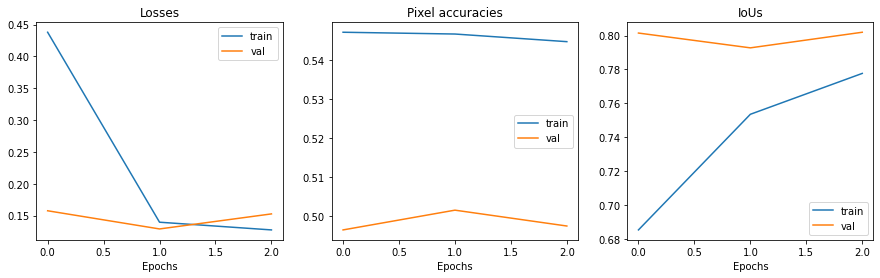

In [94]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(train_losses, label='train')
axes[0].plot(val_losses, label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_title('Losses')
axes[0].legend()

axes[1].plot(train_accs, label='train')
axes[1].plot(val_accs, label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_title('Pixel accuracies')
axes[1].legend()

axes[2].plot(train_ious, label='train')
axes[2].plot(val_ious, label='val')
axes[2].set_xlabel('Epochs')
axes[2].set_title('IoUs')
axes[2].legend()

In [95]:
# Initialise a UNet() model 
#ResNetUNet(1,encoder = best_model.encoder)
ResNetUNet(1,encoder = torchvision.models.resnet18(pretrained=True))
# Load pretrained weights
model.load_state_dict(torch.load('./weights/segmentation_model.pth'))
# Move to device (GPU or CPU)
model.to(device);

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [96]:
from sklearn.metrics import confusion_matrix, accuracy_score, jaccard_score

def get_metrics(true, preds):
    matrix = confusion_matrix(true.flatten(), preds.flatten())
    class_0, class_1 = matrix.diagonal() / matrix.sum(axis=1)
    print('***************** Metrics *****************')
    print('Class 0 (no water) accuracy: {:.3f}'.format(class_0))
    print('Class 1 (water) accuracy: {:.3f}'.format(class_1))
    print('Overall accuracy: {:.3f}'.format(accuracy_score(true.flatten(), preds.flatten())))
    print('Equally Weighted accuracy: {:.3f}'.format(0.5 * class_0 + 0.5 * class_1))
    print('IoU: {:.3f}'.format(jaccard_score(true.flatten(), preds.flatten())))
    print('*******************************************')

In [103]:
def display_outputs(idx=None, multi=False):
    # Pick a random index if none is specified
    if not idx:
        idx = random.randint(0, len(valset))
    print('Validation image ID: {}'.format(idx))
    
    # Get Sentinel 2 and Sentinel 1 data
    s2_data = torch.unsqueeze(valset.__getitem__(idx)['s2_img'].float().to(device), 0)
    s1_data = torch.unsqueeze(valset.__getitem__(idx)['s1_img'].float().to(device), 0)
    
    # Get predictions from the model
    if multi:
        output = model(s1_data, s2_data)
    else:
        output = model(s2_data)
    
    # Threshold the output to generate the binary map (FYI: the threshold value "0" can be tuned as any other hyperparameter)
    output_binary = torch.zeros(output.shape)
    output_binary[output >= 0] = 1
    
    get_metrics(valset.__getitem__(idx)['mask'], output_binary)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    axes[0].imshow(np.transpose(valset.__getitem__(idx)['s2_img'][[3,2,1],:,:], (1, 2, 0)) / valset.__getitem__(idx)['s2_img'].max())
    axes[0].set_title('True Color Sentinel-2')
    axes[2].imshow(valset.__getitem__(idx)['mask'], cmap='Blues')
    axes[2].set_title('Groundtruth')
    axes[1].imshow(output_binary.squeeze(), cmap='Blues')
    axes[1].set_title('Predicted Mask')

Validation image ID: 3
***************** Metrics *****************
Class 0 (no water) accuracy: 0.999
Class 1 (water) accuracy: 0.937
Overall accuracy: 0.992
Equally Weighted accuracy: 0.968
IoU: 0.932
*******************************************


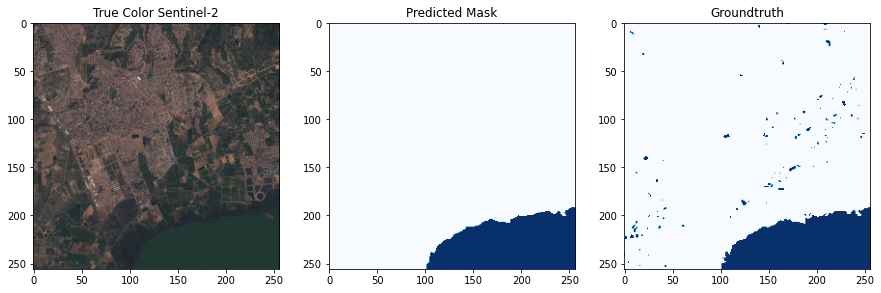

In [104]:
display_outputs()